# 1. Introduction

Welcome to this notebook where we will venture into the world of Machine Learning with one of its simplest, yet powerful techniques: Linear Regression. Here, we will predict the median price of homes in various Boston neighborhoods, using the widely-used Boston Housing dataset. This is a regression task, meaning we are trying to predict a continuous value (house prices) rather than a discrete label (e.g., spam or not-spam). Let's dive right in!

# 2. Importing the Necessary Libraries

As a good practice, we always start by importing all the libraries we'll need at the top. This makes it clear what our dependencies are, and ensures we have everything we need before we start coding.

In [141]:
import os 
import pandas as pd
import numpy as np 
import torch
from torchvision.io import read_image
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch.nn.functional as F

In [142]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# 3. Loading the Dataset

Now, let's load the Boston Housing dataset.

In [107]:
class CIFAR10_CustomDataset(Dataset):
    def __init__(self, num_batches=5, test_data=False, data_path="../data/", folder_name="cifar-10-batches-py", transform=None, label_transform=None):
        self.num_batches = num_batches
        self.transform = transform
        self.label_transform = label_transform
        self.data_path = data_path
        self.folder_name = folder_name

        self.data = []
        self.labels = []
        self.label_names = []

        label_names_dict = self.unpickle(os.path.join(data_path, folder_name, 'batches.meta'))
        self.label_names = label_names_dict[b'label_names']

        if test_data:
            data_dict = self.unpickle(os.path.join(data_path, folder_name, 'test_batch'))
            self.data.append(data_dict[b'data'])
            self.labels.append(data_dict[b'labels'])
        else:
            for i in range(1, num_batches+1):
                data_dict = self.unpickle(os.path.join(data_path, folder_name, 'data_batch_{}'.format(i)))
                self.data.append(data_dict[b'data'])
                self.labels.append(data_dict[b'labels'])
        
        # Decode to utf-8
        self.label_names = [x.decode('utf-8') for x in self.label_names]

        # Concatenate all the data and labels
        self.data = np.concatenate(self.data).reshape(-1, 3, 32, 32)
        self.labels = np.concatenate(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label        

    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def show_image(self, idx):
        plt.imshow(self.data[idx].transpose(1, 2, 0))
        plt.title(self.label_names[self.labels[idx]])
        plt.show()

# 4. Preprocessing for EDA ( if necessary )

In [143]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [144]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# 5. Exploratory Data Analysis ( EDA )

Before we dive into modeling, it's a good idea to explore our dataset. This can include looking at the raw data, checking for missing values, visualizing the distributions of variables, and understanding the relationships between different variables. See at `cheatsheets/...` for a Cheat Sheet on all the basic things to look for.

In [4]:
# No need

# 6. Data Preprocessing

Before we dive into modeling, it's a good idea to explore our dataset. This can include looking at the raw data, checking for missing values, visualizing the distributions of variables, and understanding the relationships between different variables. See at `cheatsheets/Preprocessing.md` for a Cheat Sheet on all the basic things to look for.

In [145]:
# train_data = CIFAR10_CustomDataset(test_data=False, transform=tranform)
# test_data = CIFAR10_CustomDataset(test_data=True, transform=tranform)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

# 7. Model Implementation

Finally, we come to the heart of our notebook: implementing the Linear Regression model! We'll fit the model to our training data and make predictions on our testing data.

In [146]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1  = nn.Linear(16 * 5 * 5, 120)
        self.fc2  = nn.Linear(120, 84)
        self.fc3  = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [147]:
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [148]:
num_epochs = 10

running_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if i % 2000 == 1999:
            print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, np.mean(running_loss)))

[1, 2000] loss: 2.3020380367040634
[1, 4000] loss: 2.3009369457960127
[1, 6000] loss: 2.2992586083809536
[1, 8000] loss: 2.295315094232559
[1, 10000] loss: 2.2832770945072176
[1, 12000] loss: 2.256914022088051
[2, 2000] loss: 2.2120393369115634
[2, 4000] loss: 2.1798384481415605
[2, 6000] loss: 2.148251631698093
[2, 8000] loss: 2.1168837719457905
[2, 10000] loss: 2.089891138619847
[2, 12000] loss: 2.064040491950755
[3, 2000] loss: 2.0335131165561853
[3, 4000] loss: 2.009151073525692
[3, 6000] loss: 1.9881725249867286
[3, 8000] loss: 1.9671438406344617
[3, 10000] loss: 1.9478481090579713
[3, 12000] loss: 1.9286005257738603
[4, 2000] loss: 1.9058382930106754
[4, 4000] loss: 1.88929309168063
[4, 6000] loss: 1.8729790903610746
[4, 8000] loss: 1.8571055228304076
[4, 10000] loss: 1.8416933927247399
[4, 12000] loss: 1.8279981495810278
[5, 2000] loss: 1.8106241663797544
[5, 4000] loss: 1.7974841457125212
[5, 6000] loss: 1.7850264632377242
[5, 8000] loss: 1.7725842324505592
[5, 10000] loss: 1.7

# 8. Model Evaluation

After we've made our predictions, we need to evaluate how well our model did. This will usually involve some sort of error metric, like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

In [138]:
test_accuracy = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_accuracy.append(100 * correct / total)

<Axes: >

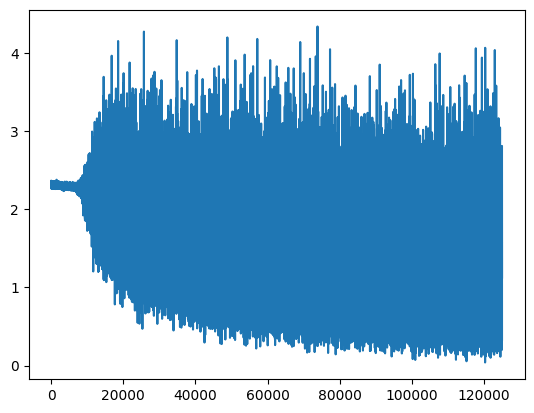

In [149]:
sns.lineplot(x=range(len(running_loss)), y=running_loss)

<Axes: >

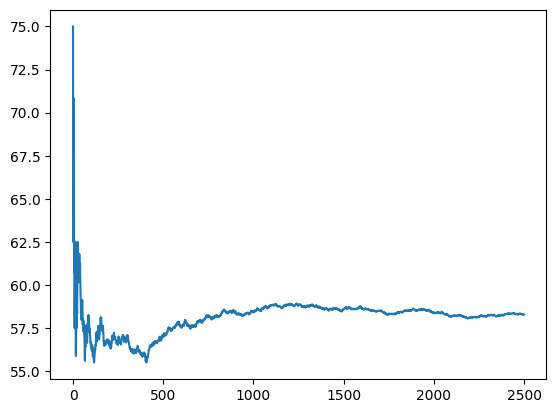

In [140]:
sns.lineplot(x=range(len(test_accuracy)), y=test_accuracy)

# 9. Conclusion

In this final section, we'll recap what we've done and learned in this notebook. We might also discuss what we could do in future projects or how we could improve our current model.

Remember, these are just guidelines. Your notebook should reflect your own style and approach to data science. The most important thing is that your notebook is clear, logical, and informative. Happy coding!

Note: You can insert these section headings into your Jupyter notebook by changing a cell's type to "Markdown" and typing in the text. You can run a markdown cell in the same way you'd run a code cell (Shift+Enter).

--- Conclusion ---